In [1]:
#INDEX 

#1. variables: user changes as needed - this should be the only part you have to change
#2. dependencies and functions
#3. get and process dff from file 
#4. read touch sensor data and save when touch sensors are active 
#5. calculate position per frame based on which touch sensors are active and make indices for movement bouts
#6. calculate whether mouse is going forward or backward per movement bout 
#7. make dataframe categorizing each individual touch into forward or backward 
#8. for each touch duration, count back 1 second from the first time touched and average all values per sensor-direction
#9. make and save figures of average dff for each sensor 

In [2]:
#VARIABLES

FPname = '/Users/riccellit/Desktop/27/27_second_1.mat'#Full path and file name of the FP mat file 
Sensorname = '/Users/riccellit/Desktop/sensordata/cwa_S27_session01_seq2_gr00_1.mat'#Full path and file name of sensor mat file 
fps = 30 
Subject = 'S27' #mouse name for saving files 
identifier = 'seq2_1' #unique name identifiers you want on file 
save_dir = '/Users/riccellit/Desktop/folder' #directory to save figures in 

In [3]:
#DEPENDENCIES AND FUNCTIONS

#ignore deprecation warnings
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os, sys 
import scipy.io as sio
import h5py
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy.ma as ma
import statsmodels.stats.weightstats as sms


#function to identify 1 location in array 
def one_runs(a):
    # Create an array that is 1 where a is 1, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 1).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

#function to identify 0 location in array 
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

#graph the linear regression 
def graph(lambdafx, x_range):  
    x = np.array(x_range)  
    y = lambdafx(x) 
    ax = plt.plot(x, y, color = 'tab:blue') 

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
#READ DFF DATA  

#there are a crap ton of extra brackets so getting rid of them here and 
#just saving the dFF signal as dFF

#The variable data is a dict with the variables and values contained in the MAT-file.
test = sio.loadmat(FPname)
signal = test['signal']  
alld =[]
for array in signal: 
    for array in array: 
        for array in array: 
            for array in array: 
                alld.append(array)
dFF =alld[4]    

In [5]:
#READ TOUCH SENSOR DATA 

f = h5py.File(Sensorname, 'r')

Sensor = []

#shape is approximating number frames 
struArray = f['sns']
shape = struArray['sns'].shape
shape = shape[0] - 1 

while shape > 0: 
    value = f[struArray['sns'][shape,0]].value 
    Sensor.append(value)
    shape = shape - 1 
            
#remove extraneous array bracket 
frames = np.array([e[0] for e in Sensor])

#find location of 1 runs where 1 indicates touch and 0 indicates no touch(e.g. frames with touches)
OnesLoc = []
for array in frames.T: 
    OnesLoc.append(one_runs(array))

In [60]:
#GET POSITION OF MOUSE

#parse out reward ports 
frames = frames.T[5:94]
frames = frames.T

#get average position based on sensors activated 
position = []
for array in frames: 
    sensorindices = [i for i, x in enumerate(array) if x == 1]
    position.append(np.nanmean(sensorindices))

mask = ma.masked_invalid(position)
mask2 = [int(x) for x in ma.getmask(mask)]

diff = np.diff((np.asarray(mask2)).flatten())
indices = [i for i, x in enumerate(diff) if x != 0]

#Add in the first and last indices as they will not be caught by the mask (eg, 0, max length)
indices.append(len(frames)) 
indices = [0] + indices
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


CORRECT NUMBER OF INDICES


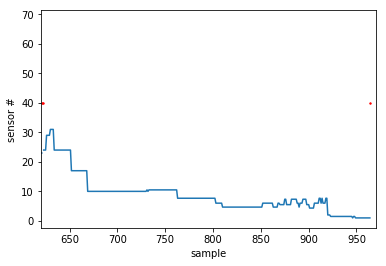

In [89]:
#QUICK CHECK INDICES 

start = 0 
stop = 1000
plt.plot(position)
plt.scatter(indices, [40] * len(indices), s = 2, c = 'r')
plt.xlim(start,stop)
plt.xlabel('sample') 
plt.ylabel('sensor #')

if len(indices) %2 == 0:
    print("CORRECT NUMBER OF INDICES") 
else: 
    print("ERROR: INCORRECT NUMBER INDICES, SEE GRAPH AND MANUALLY REMOVE BAD INDEX POINT FROM ARRAY 'indices' with del indices[i]")

In [90]:
#FIND DIRECTION OF MOVEMENT BOUT 


#where 1 is forward, 0 is backward 
#basically simple subtraction of position at beginning and end 
direction = []
for i,x in enumerate(indices):
    if i < len(indices)-2: #because comparison won't work for last index 
        if (i+2)%2 == 0:  #if the number is even 
            if position[(indices[i]+1)] - (position[indices[i+1]]) > 0: 
                direction.append(1) #forward
            elif position[(indices[i]+1)] - (position[indices[i+1]]) < 0: 
                direction.append(0) #backward 
            else: 
                direction.append(None)
        else: 
            direction.append(direction[-1]) #append the last value 
    else: 
        direction.append(direction[-1]) #append the last value 
        
#making dataframe for visualization purposes and also functions
d = {'indices':indices, 'direction':direction}
df = pd.DataFrame(data=d)

#making boolean mask of indices for forward and backward movement 
df['notna'] = pd.notna(df['direction'])
df['forward'] = df['direction'] ==1
df.forward = df.forward.astype(int)
df['backward'] = df['direction'] == 0
df.backward = df.backward.astype(int)

#get ranges and convert ranges from frames to ms
forwardRanges = []
backwardRanges = []

for index, boolean in enumerate(df['forward'].values, start=0): 
    if boolean == 1: 
        forwardRanges.append([((df['indices'][index])/fps)*1000, ((df['indices'][index+1])/fps)*1000])
    else: 
        pass 
for index, boolean in enumerate(df['backward'].values, start=0): 
    if boolean == 1: 
        backwardRanges.append([((df['indices'][index])/fps)*1000, ((df['indices'][index+1])/fps)*1000])
    else: 
        pass 


In [ ]:
#MAKE DATAFRAME OF SENSOR TOUCHES AND APPEND DIRECTION VALUES TO THOSE TOUCHES 

touches = []
sensorID = []
frame1 = [] 
frame2 = []

for i,v in enumerate(OnesLoc):
    if len(v) != 0:
        if i < 95 and i > 5: 
            for thing in v: 
                touches.append(thing)
                sensorID.append(i)
                frame1.append((thing[0]/fps)*1000)
                frame2.append((thing[1]/fps)*1000)
            else: 
                pass
        else: 
            pass
        
#find duration in seconds for which each sensor was active 
duration = (((np.asarray(frame1) - np.asarray(frame2))* -1)/fps) *1000

#make dataframe and sort by the first frame at which the sensor active 
d = {'sensorID': sensorID, 'frame': touches, 'frame1' : frame1, 'frame2' : frame2, 'duration': duration,}
df = pd.DataFrame(data=d)
df['index'] = df.index

#asking if first touch is within backward or forward movement bout ranges
forward =[]
variable = df['frame1'].values
for array in forwardRanges: 
    for i,value in enumerate(df['frame1'].values): 
        if value < array[1]:
            if value > array[0]: 
                forward.append(i)
            else: 
                pass 
        else: 
            pass
backward =[]
variable = df['frame1'].values
for array in backwardRanges: 
    for i,value in enumerate(df['frame1'].values): 
        if value < array[1]: 
            if value > array[0]: 
                backward.append(i)
            else: 
                pass 
        else: 
            pass
        
#making new column indicating whether each touch is "forward" (1) or "backward" (2)
fwdarray = []
for i in df.index.values: 
    if i in forward: 
        fwdarray.append(1)
    else: 
        fwdarray.append(0)
df['forward'] = fwdarray
        
bckarray = [] 
for i in df.index.values: 
    if i in backward: 
        bckarray.append(1)
    else: 
        bckarray.append(0)
df['backward'] = bckarray


In [ ]:
#MAKE MATRIX OF DFF VALUES FOR EACH SENSOR

#For each sensor, make a matrix containing dFF values for 1 second before first touch, separated by direction of travel
forward_dff = []
backward_dff = []

for sensor in np.unique(sensorID): 
    fd = df[df.sensorID == sensor]
    fd = fd[fd.forward == 1]
    fd = fd.reset_index() #because your numbers will be off from cropping
    dff_values = []
    for index, firsttouch in enumerate(fd['frame1'].values):
        if index < (len(fd['frame1'].values)-1): 
            if (fd['frame'][index][1]) - (fd['frame'][index+1][0]) < -5: #this is to ensure it's not just the mouse repositioning
                dff_values.append(dFF[(int(firsttouch)-1000): int(firsttouch)]) # count back a second
            else: 
                pass
        else: 
            dff_values.append(dFF[(int(firsttouch)-1000): int(firsttouch)])
    forward_dff.append(dff_values)
            
    bk = df[df.sensorID == sensor]
    bk = bk[bk.backward == 1]
    bk = bk.reset_index() #because your numbers will be off from cropping
    dff_values = []
    for index, firsttouch in enumerate(bk['frame1'].values):
        if index < (len(bk)-1): 
            if (bk['frame'][index][1]) - (bk['frame'][index+1][0]) < -5: #this is to ensure it's not just the mouse repositioning
                dff_values.append(dff_values.append(dFF[(int(firsttouch)-1000): int(firsttouch)])) # count back a second
            else: 
                pass
        else: 
            dff_values.append(dFF[(int(firsttouch)-1000): int(firsttouch)])
    backward_dff.append(dff_values)
    
#some clean up so assured all dff arrays have len/size 
cleanF = []
for array in forward_dff: 
    F = []
    for array in array: 
        if array is not None: 
            F.append(array)
    cleanF.append(F)

cleanB = []
for array in backward_dff: 
    B = []
    for array in array: 
        if array is not None: 
            B.append(array)
    cleanB.append(B)
        

In [ ]:
#GRAPH AND SAVE FIGURES OF EACH AVERAGED TRACE PER SENSOR/DIRECTION

for i,array in enumerate(cleanF): 
    tempdf = pd.DataFrame(np.asmatrix(cleanF[i])).T
    tempdf['average signal'] = tempdf.mean(axis=1)
    lowCI = []
    highCI = []
    for row in tempdf.iterrows():
        index, data = row
        lowCI.append(sms.DescrStatsW(data[0:len(data)-1]).tconfint_mean()[0])
        highCI.append(sms.DescrStatsW(data[0:len(data)-1]).tconfint_mean()[1])
    plt.title('sensor ' + str((np.unique(sensorID)[i])))
    plt.plot(list(range(-1000,0)),tempdf['average signal'])
    plt.fill_between(list(range(-1000,0)), lowCI, highCI, facecolor='tab:blue', alpha = 0.2)
    plt.ylim(-2,4)
    plt.ylabel('dFF')
    plt.xlabel('ms before reach')
    plt.vlines(0, -2,4, colors = 'r', label = "reach end")
    plt.legend()
    plt.savefig('/Users/riccellit/Desktop/folder/' + str(Subject) + '_' + identifier + '_' + 
        str((np.unique(sensorID)[i])) + '_F')
    plt.show()

for i,array in enumerate(cleanB): 
    tempdf = pd.DataFrame(np.asmatrix(cleanB[i])).T
    tempdf['average signal'] = tempdf.mean(axis=1)
    lowCI = []
    highCI = []
    for row in tempdf.iterrows():
        index, data = row
        lowCI.append(sms.DescrStatsW(data[0:len(data)-1]).tconfint_mean()[0])
        highCI.append(sms.DescrStatsW(data[0:len(data)-1]).tconfint_mean()[1])
    plt.title('sensor ' + str((np.unique(sensorID)[i])))
    plt.plot(list(range(-1000,0)),tempdf['average signal'])
    plt.fill_between(list(range(-1000,0)), lowCI, highCI, facecolor='tab:blue', alpha = 0.2)
    plt.ylim(-2,4)
    plt.ylabel('dFF')
    plt.xlabel('ms before reach')
    plt.vlines(0, -2,4, colors = 'r', label = "reach end")
    plt.legend()
    plt.savefig('/Users/riccellit/Desktop/folder/' + str(Subject) + '_' + identifier + '_' + 
                str((np.unique(sensorID)[i])) + '_B')
    plt.show()
    
    